# Fitting a Kernel Ridge Regression Model with a Coulomb Matrix
This notebook show how to use [DScribe](https://singroup.github.io/dscribe/latest/index.html) and [Kernel Ridge Regression](https://scikit-learn.org/stable/modules/kernel_ridge.html#kernel-ridge) to fit a model using the [Coulomb Matrix](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.108.058301) method.

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from dscribe.descriptors import CoulombMatrix
from ase.io.xyz import read_xyz
from io import StringIO
import pandas as pd
import numpy as np

## Load in Sample Data
The same subsample of QM9 we have used in previous exercises. We will read it in and convert it into a format useful to DScribe.

In [2]:
data = pd.read_json('../datasets/qm9.json.gz', lines=True)

DScribe is built to interface with the [Atomic Simulation Environment (ase)](https://wiki.fysik.dtu.dk/ase/) - a library that supports many tools for atom-scale modeling. So, we are going to convert the data into [ASE "Atoms" objects](https://wiki.fysik.dtu.dk/ase/ase/atoms.html).

We need the 3D coordinates of each molecule, which are stored in the XYZ format.

In [3]:
print(data['xyz'].iloc[0])

22
Properties=species:S:1:pos:R:3 unique_id=ef4cdf48825f07674198527d13db3dc3 pbc="F F F"
C      -0.17614419       1.39345250      -0.43811956 
C      -0.10132148      -0.08319296      -0.20355091 
C      -1.09461082      -0.93598396       0.08985599 
C      -0.56360192      -2.33047133       0.37869574 
C       0.88516072      -2.28325019      -0.15816488 
C       1.24464651      -0.78046234      -0.19160858 
C      -2.54443201      -0.65136129       0.24608243 
C      -3.32420388       0.12403331      -0.75238071 
N      -3.52628769      -1.33123661      -0.63493168 
H       0.46084631       1.92711776       0.27957779 
H       0.20027334       1.65730407      -1.43517277 
H      -1.19160754       1.78019296      -0.33879310 
H      -0.59344147      -2.52969714       1.46039334 
H      -1.16327028      -3.12038045      -0.08786904 
H       1.58237317      -2.87632366       0.43897106 
H       0.90888906      -2.68629980      -1.17590800 
H       1.86609861      -0.51106442      -1.054

This format can be read by ase, but we need some tricks to make it work. The [`read_xyz` function](https://wiki.fysik.dtu.dk/ase/_modules/ase/io/xyz.html#read_xyz) takes a file as input and returns a generator of Atoms object. We turn our string-format into a file-like object using [`StringIO`](https://docs.python.org/3/library/io.html#io.StringIO) and call `next` to remove the data from the generator.

In [4]:
data['atoms'] = data['xyz'].map(lambda x: next(read_xyz(StringIO(x), slice(None))))  # Lambda makes a temporary function

In [5]:
atoms = data['atoms'].iloc[0]

## Compute the Coulomb Matrix
DScribe has a few options with the Coulomb Matrix, allowing you to use it different ways.

A first option is to return the full Coulomb matrix.

In [6]:
cm = CoulombMatrix(40, permutation='none', flatten=False)  # 40 defines the size of the array
r = cm.create(data['atoms'].iloc[0])

In [7]:
atoms2 = data['atoms'].iloc[0].copy()

You can also return an array sorted by the norm of the rows, which defines a unique order to the atoms. This fits the "unique" criterion of representations as the `create` function will return the same matrix regardless of how you number the atoms.

In [8]:
cm = CoulombMatrix(40, permutation='sorted_l2', flatten=False)
cm.create(data['atoms'].iloc[0])

array([[53.3587074 , 16.35517711, 11.44193494, ...,  0.        ,
         0.        ,  0.        ],
       [16.35517711, 36.8581052 , 26.83308547, ...,  0.        ,
         0.        ,  0.        ],
       [11.44193494, 26.83308547, 36.8581052 , ...,  0.        ,
         0.        ,  0.        ],
       ...,
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

We want the eigenvalues of the matrix, which are accessible by flattening it.

In [9]:
cm = CoulombMatrix(40, permutation='eigenspectrum')
cm.create(data['atoms'].iloc[0])

array([[ 1.68134501e+02,  6.48085518e+01,  3.83920805e+01,
         2.79904445e+01,  1.95189692e+01,  1.66540903e+01,
         1.17890333e+01,  8.83261885e+00,  3.40122666e+00,
        -9.34620750e-01, -8.92017655e-01, -7.82414910e-01,
        -6.58229431e-01, -4.90163018e-01, -3.67224705e-01,
        -2.75108095e-01, -1.65192791e-01, -1.21944806e-01,
        -8.85454287e-02,  7.10197837e-02, -6.07606172e-02,
        -3.27645940e-02,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

We now show a simple way to compute the Coulomb matrix for all molecules in our training set

In [10]:
%%time
cms = cm.create(data['atoms'], n_jobs=2)  # Runs in parallel with 2 workers

CPU times: user 1.64 s, sys: 27.1 ms, total: 1.66 s
Wall time: 5.36 s


In [11]:
data['cm'] = cms.tolist()  # Makes it possible to set array values in a Pandas dataframe

## Training a KRR Model
We are going to use a Gaussian kernel as the basis of our model, following the original work of Rupp et al. 

We build this model using the [KernelRidge](https://scikit-learn.org/stable/modules/generated/sklearn.kernel_ridge.KernelRidge.html) model using the [radial basis function (RBF) kernel](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.rbf_kernel.html#sklearn.metrics.pairwise.rbf_kernel).

In [12]:
model = Pipeline([
    ('scale', StandardScaler()),
    ('krr', KernelRidge(kernel='rbf'))
])

Let's make a training and test set to start off with

In [13]:
train_data, test_data = train_test_split(data, train_size=1000, test_size=1000)

Try to fit a model for atomization energy (`u0_atom`) with default parameters

In [14]:
# np.vstack converts list to a big matrix
model.fit(np.vstack(train_data['cm']), train_data['u0_atom'])

Pipeline(steps=[('scale', StandardScaler()),
                ('krr', KernelRidge(kernel='rbf'))])

In [15]:
y_pred = model.predict(np.vstack(test_data['cm']))

Text(0, 0.5, '$E_{atom}$, ML (Ha)')

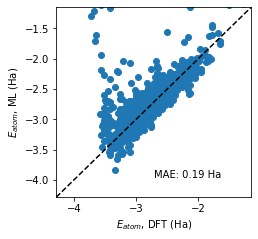

In [16]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['u0_atom'], y_pred)

# Make a y=x line
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.text(0.5, 0.1, f'MAE: {mean_absolute_error(y_pred, test_data["u0_atom"]):.2f} Ha',
       transform=ax.transAxes)
ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')

Most of the points lie along the line, so the model is working. But, we can do better.

## Fitting Hyperparameters for KRR
The are two key parameters for ridge regression:

1. $\alpha$: Controls the strength of the fitting. Larger values penalize the model from fitting closely to the data, biasing it towards simpler models.
2. $\gamma$: Controls the "smoothness" of the model

We are going to fit these models using [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html): a tool in Scikit-Learn for fitting the hyperpameters of a machine learning models. It runs a series of cross-validation experiments and determines which parameters perform the best.

*Note*: We use the term "hyperparameters" to describe those options that control how a machine learning algorithm learns, which is in constrast to the "parameters" that could be learned from the data (e.g., the coefficients of a linear regression model).

In [17]:
gs = GridSearchCV(
    model,  # The model I would like to tune
    {'krr__gamma': np.logspace(-8, 2, 32)},  # The parameters to be adjusted
    cv=10,  # How I perform the cross-validation (here: 10-fold cross-validation),
    scoring='neg_mean_squared_error'  # Negative mean squared error, so that better models have greater values
)

In [18]:
%%time
gs.fit(np.vstack(train_data['cm']), train_data['u0_atom']);

CPU times: user 1min 8s, sys: 2min 21s, total: 3min 30s
Wall time: 8.78 s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('krr', KernelRidge(kernel='rbf'))]),
             param_grid={'krr__gamma': array([1.00000000e-08, 2.10174801e-08, 4.41734470e-08, 9.28414545e-08,
       1.95129342e-07, 4.10112707e-07, 8.61953566e-07, 1.81160919e-06,
       3.80754602e-06, 8.00250228e-06, 1.68192432e-05, 3.53498111e-05,
       7.42963951e-05, 1.56152301e-04, 3.28192787e-04, 6.89778538e-04,
       1.44974067e-03, 3.04698957e-03, 6.40400427e-03, 1.34596032e-02,
       2.82886943e-02, 5.94557071e-02, 1.24960914e-01, 2.62636353e-01,
       5.51995432e-01, 1.16015530e+00, 2.43835410e+00, 5.12480588e+00,
       1.07710506e+01, 2.26380341e+01, 4.75794431e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

Plot the results

Text(0, 0.5, 'MAE (Ha)')

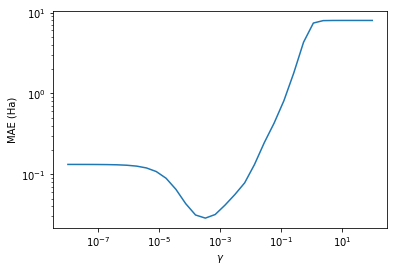

In [19]:
fig, ax = plt.subplots()

params = pd.DataFrame(gs.cv_results_['params'])
ax.loglog(params['krr__gamma'], -gs.cv_results_['mean_test_score'])

ax.set_xlabel('$\gamma$')
ax.set_ylabel('MAE (Ha)')

See how well the best model performed

In [20]:
model = gs.best_estimator_

In [21]:
model.fit(np.vstack(train_data['cm']), train_data['u0_atom'])
y_pred = model.predict(np.vstack(test_data['cm']))

Text(0, 0.5, '$E_{atom}$, ML (Ha)')

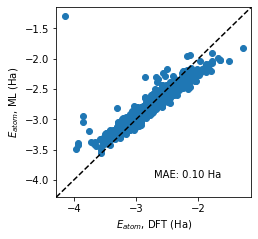

In [22]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['u0_atom'], y_pred)

# Make a y=x line
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.text(0.5, 0.1, f'MAE: {mean_absolute_error(y_pred, test_data["u0_atom"]):.2f} Ha',
       transform=ax.transAxes)
ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')

Great! We reduced the error by a factor of 2  by changing one of the two parameters. Now, lets adjust both $\alpha$ and $\gamma$

*Note*: I intentionally did not use the test data to tune the parameters of my model. The test data is kept completely separate from any method used to determine the parameters (hyperparameters or not)

In [23]:
gs = GridSearchCV(model,
    {'krr__gamma': np.logspace(-8, 2, 16), 'krr__alpha': np.logspace(-8, 2, 16)},
    cv=10,
    scoring='neg_mean_squared_error'  # Negative mean squared error, so that better models have greater values
)

In [24]:
%%time
gs.fit(np.vstack(train_data['cm']), train_data['u0_atom']);

CPU times: user 8min 8s, sys: 16min 57s, total: 25min 5s
Wall time: 1min 2s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('krr',
                                        KernelRidge(gamma=0.0003281927872511471,
                                                    kernel='rbf'))]),
             param_grid={'krr__alpha': array([1.00000000e-08, 4.64158883e-08, 2.15443469e-07, 1.00000000e-06,
       4.64158883e-06, 2.15443469e-05, 1.00000000e-04, 4.64158883e-04,
       2.15443469e-03, 1.00000000e-02, 4.64158883e-02, 2.15443469e-01,
       1....00e+00, 4.64158883e+00, 2.15443469e+01, 1.00000000e+02]),
                         'krr__gamma': array([1.00000000e-08, 4.64158883e-08, 2.15443469e-07, 1.00000000e-06,
       4.64158883e-06, 2.15443469e-05, 1.00000000e-04, 4.64158883e-04,
       2.15443469e-03, 1.00000000e-02, 4.64158883e-02, 2.15443469e-01,
       1.00000000e+00, 4.64158883e+00, 2.15443469e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

Text(0, 0.5, 'MAE (Ha)')

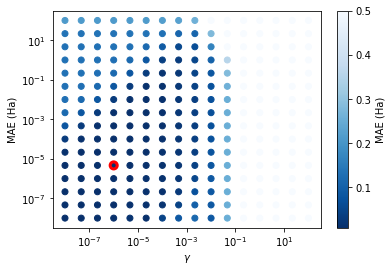

In [25]:
fig, ax = plt.subplots()

# Plot all of the parameters
params = pd.DataFrame(gs.cv_results_['params'])
sd = ax.scatter(params['krr__gamma'], params['krr__alpha'], c=-gs.cv_results_['mean_test_score'],
                vmax=0.5, cmap='Blues_r')
ax.set_xscale('log')
ax.set_yscale('log')

# Mark the best
ax.scatter(gs.best_params_['krr__alpha'], gs.best_params_['krr__gamma'], facecolor='none', edgecolor='red',
           s=50, lw=3)

fig.colorbar(sd, label='MAE (Ha)')

ax.set_xlabel('$\gamma$')
ax.set_ylabel('MAE (Ha)')

Now, see how well we do with the fully-tuned model

In [26]:
model = gs.best_estimator_

In [27]:
model.fit(np.vstack(train_data['cm']), train_data['u0_atom'])
y_pred = model.predict(np.vstack(test_data['cm']))

Text(0, 0.5, '$E_{atom}$, ML (Ha)')

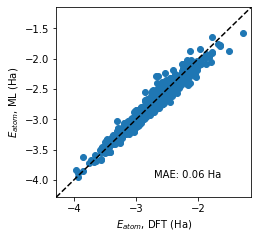

In [28]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['u0_atom'], y_pred)

# Make a y=x line
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.text(0.5, 0.1, f'MAE: {mean_absolute_error(y_pred, test_data["u0_atom"]):.2f} Ha',
       transform=ax.transAxes)
ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')

We have now reduced the error by another 40% by adjusting both parameters. Also note that some outliers have gone away. 

Parameter tuning for KRR is very important!

## Show the Need for Scalable Kernels
"Scalable Kernels" are a technique in molecular ML that make it possible for KRR models to automatically learn the linear relationship between some properties and molecular size.

Here, we demonstrate why it is possible by showing where it is a problem with Coulomb Matrix.

In [29]:
size = np.percentile(data['n_atom'], 90)
train_data = data.query(f'n_atom<={size}')
test_data = data.query(f'n_atom>{size}')
print(f'Made a training set of {len(train_data)} entries and a test set of {len(test_data)} by splitting based on molecule size.')

Made a training set of 23221 entries and a test set of 1779 by splitting based on molecule size.


Train a model on 1000 of the smaller molecules. Note that we are going to use the GridSearchCV tool to re-fit the parameters

In [30]:
train_subset = train_data.sample(1000)

In [31]:
%%time
gs.fit(np.vstack(train_subset['cm']), train_subset['u0_atom']);

CPU times: user 8min 17s, sys: 17min 10s, total: 25min 27s
Wall time: 1min 3s


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scale', StandardScaler()),
                                       ('krr',
                                        KernelRidge(gamma=0.0003281927872511471,
                                                    kernel='rbf'))]),
             param_grid={'krr__alpha': array([1.00000000e-08, 4.64158883e-08, 2.15443469e-07, 1.00000000e-06,
       4.64158883e-06, 2.15443469e-05, 1.00000000e-04, 4.64158883e-04,
       2.15443469e-03, 1.00000000e-02, 4.64158883e-02, 2.15443469e-01,
       1....00e+00, 4.64158883e+00, 2.15443469e+01, 1.00000000e+02]),
                         'krr__gamma': array([1.00000000e-08, 4.64158883e-08, 2.15443469e-07, 1.00000000e-06,
       4.64158883e-06, 2.15443469e-05, 1.00000000e-04, 4.64158883e-04,
       2.15443469e-03, 1.00000000e-02, 4.64158883e-02, 2.15443469e-01,
       1.00000000e+00, 4.64158883e+00, 2.15443469e+01, 1.00000000e+02])},
             scoring='neg_mean_squared_error')

Plot the model performance

In [32]:
model = gs.best_estimator_

In [33]:
model.fit(np.vstack(train_subset['cm']), train_subset['u0_atom'])
y_pred = model.predict(np.vstack(test_data['cm']))

Text(0, 0.5, '$E_{atom}$, ML (Ha)')

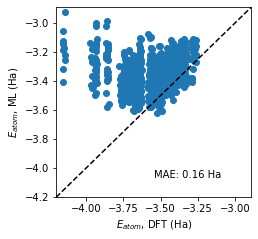

In [34]:
fig, ax = plt.subplots(figsize=(3.5, 3.5))

ax.scatter(test_data['u0_atom'], y_pred)

# Make a y=x line
min_value = min(ax.get_xlim() + ax.get_ylim())
max_value = max(ax.get_xlim() + ax.get_ylim())
ax.set_xlim((min_value, max_value))
ax.set_ylim(ax.get_xlim())
ax.plot(ax.get_xlim(), ax.get_xlim(), 'k--')

ax.text(0.5, 0.1, f'MAE: {mean_absolute_error(y_pred, test_data["u0_atom"]):.2f} Ha',
       transform=ax.transAxes)
ax.set_xlabel('$E_{atom}$, DFT (Ha)')
ax.set_ylabel('$E_{atom}$, ML (Ha)')

The error here is much larger than what we observed in a previous test.

This brings us to our key points from this notebook:
1. *You must tune hyperparameters with KRR.* In our demo here, we can see an improvement of 3-4x and the elimination of outlier predictions.
1. *Coulomb Matrix, which lacks a scalable kernel, cannot predict the energies of molecules larger than the training set.* Consider (and maybe, test!) whether this would be a problem for other properties.
1. *Validate models in the way you want to use them*. If I intended to use my model to predict the properties of large molecules, a simple "split randomly" cross validation test would be very misleading.